## Re-fit dynamical runs 

In [1]:
#import gsw as sw # Gibbs seawater package

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.gridspec as gspec
%matplotlib inline
from matplotlib.ticker import FormatStrFormatter
from netCDF4 import Dataset
import numpy as np
import os
import pandas as pd
import seaborn as sns
import sys
import scipy.stats
import warnings
warnings.filterwarnings("ignore")
import xarray as xr

import canyon_tools.readout_tools as rout 
import canyon_tools.metrics_tools as mpt

In [2]:
sns.set_context('talk')
sns.set_style('white')

In [3]:
CanyonGrid='/data/kramosmu/results/TracerExperiments/CNTDIFF/run38/gridGlob.nc'
CanyonGridOut = Dataset(CanyonGrid)

CanyonGridNoC='/data/kramosmu/results/TracerExperiments/CNTDIFF/run68/gridGlob.nc'
CanyonGridOutNoC = Dataset(CanyonGridNoC)

CanyonState='/data/kramosmu/results/TracerExperiments/CNTDIFF/run38/stateGlob.nc'
CanyonStateOut = Dataset(CanyonState)

# Grid variables
nx = 616
ny = 360
nz = 90
nt = 19 # t dimension size 
time = CanyonStateOut.variables['T']

In [4]:
# Constants and scales

g = 9.81 # accel. gravity
Hs = 149.8 # Shelf break depth
s = 0.01 # shelf slope 

def Dh(f,L,N):
    '''Vertical scale Dh'''
    return((f*L)/(N))
    
def Ro(U,f,R):
    '''Rossby number'''
    return(U/(f*R))

def F(Ro):
    '''Function that estimates the ability of the flow to follow isobaths'''
    return(Ro/(0.9+Ro))

def Bu(N,f,W,Hs):
    '''Burger number'''
    return((N*Hs)/(f*W))

def RossbyRad(N,Hs,f):
    '''1st Rossby radius of deformation'''
    return((N*Hs)/f)

def SE(s,N,f,Fw,Rl):
    '''Slope effect '''
    return((s*N)/(f*(Fw/Rl)**0.5))

In [5]:
# Information for all runs is stored in canyon_records.py
lib_path = os.path.abspath('/ocean/kramosmu/OutputAnalysis/outputanalysisnotebooks/PythonScripts/Paper1Figures/') # Add absolute path to my python scripts
sys.path.append(lib_path)

import canyon_records 

records = canyon_records.main()

### Not all runs are used to fit the data and find the fitting constants:

**records_dyn** has all runs where f, N or U vary. USe this list to fit upwelling flux $\Phi$ and modify *Howatt and Allen 2013*.

**records_step** has all runs in records_dyn plus the runs with a step Kv profile. Use this list to fit $\Phi$ with scaled N.

**records_kv** has all runs with step Kv profile. Use this list to fit N below for step Kv runs.

**records_nokv** has all runs except the ones with step Kv profile. Use this list to fit N below.

In [6]:
# Indices of all runs that will be considered for paper 1

select_rec = [0,1,2,3,4,5,51,6,7,8,9,10,17,18,19,20,21,
              22,23,24,25,26,27,28,29,30,31,32,33,
              34,35,38,39,41,42,43,44,45,46,47,48,49,52,53,54,55,56,57,58,59,60,61]

for ii in select_rec:
    print(ii,records[ii].name)
    

0 CNTDIFF_run38
1 CNTDIFF_run37
2 CNTDIFF_run36
3 CNTDIFF_run45
4 CNTDIFF_run73
5 CNTDIFF_run75
51 CNTDIFF_run81
6 CNTDIFF_run79
7 CNTDIFF_run67
8 CNTDIFF_run51
9 CNTDIFF_run69
10 CNTDIFF_run71
17 LOWER_BF_run01
18 LOW_BF_run01
19 LOWEST_BF_run01
20 LOWEST_BF_run03
21 LOWEST_BF_run05
22 LOWEST_BF_run07
23 LOWEST_BF_run11
24 3DVISC_REALISTIC_run01
25 3DVISC_REALISTIC_run02
26 3DVISC_REALISTIC_run03
27 3DVISC_REALISTIC_run05
28 3DVISC_REALISTIC_run06
29 3DVISC_REALISTIC_run07
30 3DVISC_REALISTIC_run08
31 3DVISC_REALISTIC_run09
32 3DVISC_REALISTIC_run10
33 3DVISC_REALISTIC_run11
34 3DVISC_REALISTIC_run12
35 3DVISC_REALISTIC_run13
38 3DVISC_REALISTIC_run16
39 3DVISC_REALISTIC_run17
41 3DVISC_REALISTIC_run19
42 3DVISC_REALISTIC_run20
43 3DVISC_REALISTIC_run21
44 3DVISC_REALISTIC_run22
45 3DVISC_REALISTIC_run23
46 3DVISC_REALISTIC_run24
47 3DVISC_REALISTIC_run25
48 3DVISC_REALISTIC_run26
49 3DVISC_REALISTIC_run27
52 LONGER_CNY_run01
53 LONGER_CNY_LOWEST_U_run01
54 LONGER_CNY2_run01
55 LONGER

In [7]:
# records_dyn has all the runs without the ones where K_bg changes. Use these ones for fitting the data HA2013
ind = [0,3,4,5,51,6,7,8,9,10,17,18,19,20,21,22,52,53,54,55,56,57,58,59,60,61]
records_dyn = []
for ii in ind:
    records_dyn.append(records[ii])

# records_step has all the runs in records_dyn plus the step runs (use these to fit Phi with Nmean)
ind = [0,3,4,5,51,6,7,8,9,10,17,18,19,20,21,22,38,39,45,46,47,48,49]
records_step = []
for ii in ind:
    records_step.append(records[ii])

# records_epsilon has all the runs in records_step plus the epsilon runs (use these to fit Nmax+Nmin)
ind = [0,3,4,5,51,6,7,8,9,10,17,18,19,20,21,22,29,30,31,32,33,
       34,38,39,41,42,43,44,45,46,47,48,49]
records_epsilon = []
for ii in ind:
    records_epsilon.append(records[ii])

# records_real has all the runs in records_epsilon plus the realistic runs
ind = [0,3,4,5,51,6,7,8,9,10,17,18,19,20,21,22,29,30,31,32,33,
       34,38,41,42,39,43,44,45,46,47,48,49,24,25,26,27,28]
records_real = []
for ii in ind:
    records_real.append(records[ii])

# records_diffusivity has all the runs with step and epsilon kv profiles; it does not have the dynamics runs
ind = [29,30,31,32,33,34,38,39,41,42,43,44,45,46,47,48,49]
records_diffusivity = []
for ii in ind:
    records_diffusivity.append(records[ii])

    
# records_kv has the runs with step kv profile
ind = [28,32,37,38,44,45,46,47,48] 

records_kv = []
for ii in ind:
    records_kv.append(records[ii])

# records_nokv has the runs without step kv profile
ind = [0,3,4,5,51,6,7,8,9,10,17,18,19,20,21,22,29,30,31,32,33,34,41,42,43,44]
       
records_nokv = []
for ii in ind:
    records_nokv.append(records[ii])

# records3 has all the runs without the ones where K_bg changes and run with low U high N.
ind = [0,3,4,5,51,6,7,8,9,10,17,18,19,21,22]
records3 = []
for ii in ind:
    records3.append(records[ii])



In [8]:
records_sel = []

for ind in select_rec:
    records_sel.append(records[ind])
    file = ('/data/kramosmu/results/TracerExperiments/%s/HCW_TrMass_%s%s.csv' %(records[ind].exp_code,
                                                                                records[ind].exp_code,
                                                                                records[ind].run_num))
    dfcan = pd.read_csv(file)
    records[ind].HCW = dfcan['HCW']
    records[ind].HCWTr1 = dfcan['HCWTr1']
    records[ind].TrMass = dfcan['TrMassHCW']
    records[ind].TrMassTr1 = dfcan['TrMassHCWTr1']
    records[ind].TrMassTr2 = dfcan['TrMassHCWTr2']
    records[ind].TrMassTot = dfcan['TotTrMass']
    records[ind].TrMassTotTr2 = dfcan['TotTrMassTr2']
    records[ind].TrMassTotTr1 = dfcan['TotTrMassTr1']
    print(ind, records[ind].exp_code)

0 CNTDIFF
1 CNTDIFF
2 CNTDIFF
3 CNTDIFF
4 CNTDIFF
5 CNTDIFF
51 CNTDIFF
6 CNTDIFF
7 CNTDIFF
8 CNTDIFF
9 CNTDIFF
10 CNTDIFF
17 LOWER_BF
18 LOW_BF
19 LOWEST_BF
20 LOWEST_BF
21 LOWEST_BF
22 LOWEST_BF
23 LOWEST_BF
24 3DVISC_REALISTIC
25 3DVISC_REALISTIC
26 3DVISC_REALISTIC
27 3DVISC_REALISTIC
28 3DVISC_REALISTIC
29 3DVISC_REALISTIC
30 3DVISC_REALISTIC
31 3DVISC_REALISTIC
32 3DVISC_REALISTIC
33 3DVISC_REALISTIC
34 3DVISC_REALISTIC
35 3DVISC_REALISTIC
38 3DVISC_REALISTIC
39 3DVISC_REALISTIC
41 3DVISC_REALISTIC
42 3DVISC_REALISTIC
43 3DVISC_REALISTIC
44 3DVISC_REALISTIC
45 3DVISC_REALISTIC
46 3DVISC_REALISTIC
47 3DVISC_REALISTIC
48 3DVISC_REALISTIC
49 3DVISC_REALISTIC
52 LONGER_CNY
53 LONGER_CNY_LOWEST_U
54 LONGER_CNY2
55 LONGER_CNY2_LOWER_U
56 LONGER_CNY_LOWER_U
57 LONGER_CNY_LOWER_U
58 LONGER_CNY_LOWER_U
59 LONGER_CNY_LOWER_U
60 LONGER_CNY_LOWER_U
61 NARROW_CNY


## Re-fit HA2013
(They may have had recirculation). First look at different W's. I need W, width at mid-length at rim depth and Ws, width at mid-length at shelf break isobath.

In [9]:
sb_ind = 29

depth = CanyonGridOut.variables['Depth'][:]
Y = CanyonGridOut.variables['Y'][:]
X = CanyonGridOut.variables['X'][:]
RC = CanyonGridOut.variables['RC'][:]
hFacC = CanyonGridOut.variables['HFacC'][:]

shelf break depth is 149.8 m
rim depth at station UwH is 108.1 m
head depth is 98.8 m
L is 8332.6 m
rim depth at mid length is 126.7 m
short L is 6400.5 m
slope = (-149.82 + 97.46) / (51333.64 - 59888.45) = 0.01


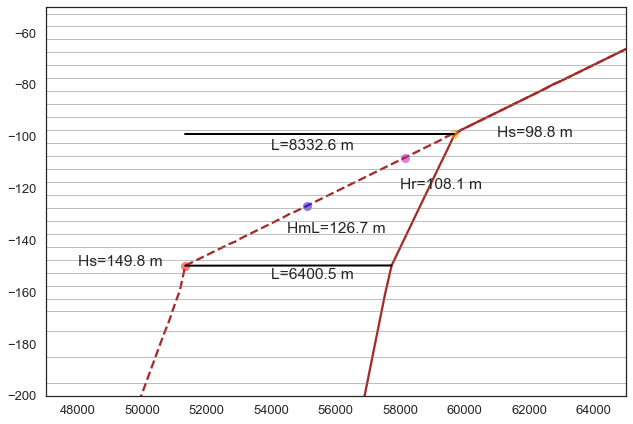

In [10]:
fig, ax = plt.subplots(1,1)

# plot canyon axis and shelf
ax.plot(Y,-depth[:,300], color='brown', linestyle='--')
ax.plot(Y,-depth[:,180], color='brown')

# Shelf break depth
ax.plot(Y[225],-depth[225,300],'ro', alpha=0.5)
print('shelf break depth is %1.1f m' %depth[225,300])
ax.text(48000,-150,'Hs=%1.1f m' %(depth[225,300]))

# rim depth at UwH
ax.plot(Y[261],-depth[261,300],'mo', alpha=0.5)
print('rim depth at station UwH is %1.1f m' %depth[261,300])
ax.text(58000,-120,'Hr=%1.1f m' %(depth[261,300]))

# Head depth
ax.plot(Y[268],-depth[268,300],'o', color='orange', alpha=0.5)
print('head depth is %1.1f m' %depth[268,300])
ax.text(61000,-100,'Hs=%1.1f m' %(depth[268,300]))

# Length
plt.plot([Y[268],Y[225]],[-depth[268,300],-depth[268,300]], linewidth=2, color='k')
print('L is %1.1f m' %(Y[268]-Y[225]))
ax.text(54000,-105,'L=%1.1f m' %(Y[268]-Y[225]))

# mid length depth
ax.plot(Y[246],-depth[246,300],'bo', alpha=0.5)
print('rim depth at mid length is %1.1f m' %depth[246,300])
ax.text(54500,-137,'HmL=%1.1f m' %(depth[246,300]))

# Short Length
plt.plot([Y[259],Y[225]],[-depth[259,180],-depth[225,300]], linewidth=2, color='k')
print('short L is %1.1f m' %(Y[259]-Y[225]))
ax.text(54000,-155,'L=%1.1f m' %(Y[259]-Y[225]))

# depth levels
for zz in range(len(RC)):
    ax.axhline(RC[zz], color='0.5', linewidth=0.5)

ax.set_ylim(-200,-50)
ax.set_xlim(47000,65000)

slope = (-depth[225,400]+depth[269,400])/(Y[225]-Y[269])

print('slope = (%1.2f + %1.2f) / (%1.2f - %1.2f) = %1.2f' %(-depth[225,400],depth[269,400],Y[225],Y[269], slope) )

Width at rim depth at mid length is 21141.7 m
Width at sb depth at mid length is 12310.3 m
Width at sb depth at mouth is 24931.8 m
L is 8332.6 m
98.8196651264


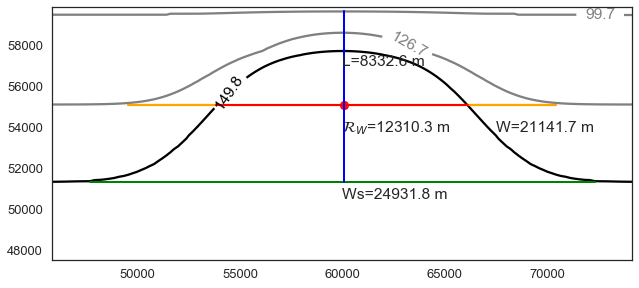

In [11]:
fig, ax = plt.subplots(1,1)

CS = ax.contour(X[100:260],Y[200:270],depth[200:270,100:260], levels=[depth[268,180],depth[246,300], 149.8], colors=['0.5','0.5','k'])
ax.clabel(CS, fmt='%1.1f')
ax.plot(X[180],Y[246],'or')

ax.plot(X[115:245],np.ones(len(X[115:245]))*Y[246],'-', color='orange')
print('Width at rim depth at mid length is %1.1f m' %(-X[115]+X[245]))
ax.text(67500,53800,'W=%1.1f m' %(-X[115]+X[245]))

ax.plot(X[137:223],np.ones(len(X[137:223]))*Y[246],'-r', linewidth=2)
print('Width at sb depth at mid length is %1.1f m' %(-X[137]+X[222]))
ax.text(60000,53800,r'$\mathcal{R}_W$=%1.1f m' %(-X[137]+X[222]))

ax.plot(X[107:253],np.ones(len(X[107:253]))*Y[225],'-g', linewidth=2)
print('Width at sb depth at mouth is %1.1f m' %(-X[107]+X[253]))
ax.text(60000,50500,'Ws=%1.1f m' %(-X[107]+X[253]))

ax.plot(np.ones(len(Y[225:269]))*X[180], Y[225:269],'-b', linewidth=2)
print('L is %1.1f m' %(Y[268]-Y[225]))
ax.text(60000,57000,'L=%1.1f m' %(Y[268]-Y[225]))

ax.set_aspect(1)
print(depth[268,300])

In [12]:
# records_dyn has all runs where Kv does not change, only N, f, U

for param in np.linspace(0.2,0.6, 50):
    for rec in records_dyn:
        
        Se = SE(s, rec.N, rec.f, F(Ro(rec.u,rec.f,rec.Wiso)), Ro(rec.u,rec.f,rec.L))
        
        rec.X = ((F(Ro(rec.u,rec.f,rec.Wiso)))**(1.5))*((Ro(rec.u,rec.f,rec.L))**(0.5))*((1-param*Se)**3)

        can_eff = rec.HCW
        Phi = np.mean(np.array([(can_eff[ii]-can_eff[ii-1])/(time[ii]-time[ii-1]) for ii in range (8,18)]))
        Phi_std = np.std(np.array([(can_eff[ii]-can_eff[ii-1])/(time[ii]-time[ii-1]) for ii in range (8,18)]))
        
        rec.Phi = Phi
        rec.Phi_std = Phi_std
        rec.Phi_nonDim = rec.Phi/(rec.u*rec.W*Dh(rec.f,rec.L,rec.N))

    Y_array = np.array([rec.Phi_nonDim for rec in records_dyn])
    X_array = np.array([rec.X for rec in records_dyn])

    slope0, intercept0, r_value0, p_value0, std_err0 = scipy.stats.linregress(X_array,Y_array)

    print('Using parameter %1.2f: slope = %1.2f, intercept = %1.3f, r-value = %1.3f' %(param, slope0, intercept0, r_value0))

Using parameter 0.20: slope = 0.86, intercept = -0.000, r-value = 0.821
Using parameter 0.21: slope = 0.90, intercept = -0.000, r-value = 0.826
Using parameter 0.22: slope = 0.93, intercept = -0.001, r-value = 0.832
Using parameter 0.22: slope = 0.96, intercept = -0.001, r-value = 0.837
Using parameter 0.23: slope = 0.99, intercept = -0.001, r-value = 0.843
Using parameter 0.24: slope = 1.03, intercept = -0.002, r-value = 0.848
Using parameter 0.25: slope = 1.06, intercept = -0.002, r-value = 0.853
Using parameter 0.26: slope = 1.10, intercept = -0.002, r-value = 0.858
Using parameter 0.27: slope = 1.14, intercept = -0.003, r-value = 0.863
Using parameter 0.27: slope = 1.18, intercept = -0.003, r-value = 0.867
Using parameter 0.28: slope = 1.21, intercept = -0.003, r-value = 0.872
Using parameter 0.29: slope = 1.25, intercept = -0.004, r-value = 0.876
Using parameter 0.30: slope = 1.30, intercept = -0.004, r-value = 0.880
Using parameter 0.31: slope = 1.34, intercept = -0.004, r-value 

I got the largest r-value (0.980) for parameter values 0.87 to 0.90.  

In [13]:
param = 0.42

for rec in records_dyn:

    Se = SE(s, rec.N, rec.f, F(Ro(rec.u_mod,rec.f,rec.Wiso)), Ro(rec.u_mod,rec.f,rec.L))
    
    rec.X = ((F(Ro(rec.u_mod,rec.f,rec.Wiso)))**(1.5))*((Ro(rec.u_mod,rec.f,rec.L))**(0.5))*((1-param*Se)**3)
    
    rec.X_HA = ((F(Ro(rec.u_mod,rec.f,rec.Wiso)))**(1.5))*((Ro(rec.u_mod,rec.f,rec.L))**(0.5))*((1-1.21*Se)**3)
    
    rec.Se = Se
    can_eff = rec.HCW
    Phi = np.mean(np.array([(can_eff[ii]-can_eff[ii-1])/(time[ii]-time[ii-1]) for ii in range (8,18)]))
    Phi_std = np.std(np.array([(can_eff[ii]-can_eff[ii-1])/(time[ii]-time[ii-1]) for ii in range (8,18)]))
    
    rec.Phi = Phi
    rec.Phi_std = Phi_std
    rec.Phi_nonDim = rec.Phi/(rec.u_mod*rec.W*Dh(rec.f,rec.L,rec.N))

Y_array = np.array([rec.Phi_nonDim for rec in records_dyn])
X_array = np.array([rec.X for rec in records_dyn])

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(X_array,Y_array)
print('Using parameter %1.2f: slope = %1.2f, intercept = %1.3f, r-value = %1.3f' %(param, slope, intercept, r_value))

Using parameter 0.42: slope = 1.48, intercept = -0.007, r-value = 0.887


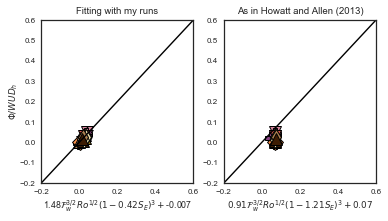

In [101]:
sns.set_context('paper')
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(6,3))

for rec in records_dyn[:-1]:
    
    if Ro(rec.u_mod,rec.f,rec.L) > 100:
        continue
    else:
        
        ax1.plot(slope*rec.X+intercept,rec.Phi_nonDim, 
                 marker = rec.mstyle,markersize = 12,
                 color = sns.xkcd_rgb[rec.color2],
                 markeredgewidth=1.0,
                 markeredgecolor = 'k',
                 label=rec.label)
        ax2.plot(0.91*rec.X_HA+0.07,rec.Phi_nonDim, 
                 marker = rec.mstyle, markersize = 12,
                 color = sns.xkcd_rgb[rec.color2],
                 markeredgewidth=1.0,
                 markeredgecolor = 'k',
                 label=rec.label)
        #ax3.plot([((F(Ro(rec.u_mod,rec.f,rec.R)))**(3/2))*((Ro(rec.u_mod,rec.f,rec.L))**(1/2))],
        #         rec.Phi/(rec.u_mod*rec.Wsb*Dh(rec.f,rec.L,rec.N)), 
        #         marker = rec.mstyle,markersize = 12,
        #         color = sns.xkcd_rgb[rec.color2],
        #         markeredgewidth=1.0,
        #         markeredgecolor = 'k',
        #         label=rec.label)
            
xx = np.linspace(-0.2,0.6,50)
ax1.plot(xx,xx,'k-')
ax2.plot(xx,xx,'k-')

ax1.set_xlim(-0.2,0.6)
ax1.set_ylim(-0.2,0.6)
ax2.set_xlim(-0.2,0.6)
ax2.set_ylim(-0.2,0.6)
ax1.set_ylabel('$\Phi/WUD_h$', labelpad=0)
ax1.set_xlabel(r'%1.2f$\mathcal{F}_w^{3/2}Ro^{1/2}(1-%1.2f S_E)^3+$%1.3f' %(slope, param, intercept))
ax2.set_xlabel(r'$0.91\mathcal{F}_w^{3/2}Ro^{1/2}(1-1.21S_E)^3+0.07$')

ax1.set_title('Fitting with my runs')
ax2.set_title(r'As in Howatt and Allen (2013)')
ax3.set_title(r'As in Allen and Hickey (2010)')

#ax2.legend(bbox_to_anchor=(1.0,1),ncol=1, columnspacing=0.1)
plt.savefig('nondim_Phi_with_HA_axis.eps', format='eps', bbox_inches='tight')

#### So, the modified scaling for upwelling flux $\Phi$ is: 


In [53]:
print(r'%1.2f$\mathcal{F}_w^{3/2}Ro^{1/2}(1-%1.2f S_E)^3+$%1.3f' %(slope, param, intercept))


1.48$\mathcal{F}_w^{3/2}Ro^{1/2}(1-0.42 S_E)^3+$-0.007


CNTDIFF_run38 9.66e-05 0.365 0.0055 8332.6 12310.3
CNTDIFF_run45 9.66e-05 0.379 0.0063 8332.6 12310.3
CNTDIFF_run73 9.66e-05 0.397 0.0074 8332.6 12310.3
CNTDIFF_run75 9.66e-05 0.346 0.0046 8332.6 12310.3
CNTDIFF_run81 9.66e-05 0.348 0.0047 8332.6 12310.3
CNTDIFF_run79 9.66e-05 0.354 0.005 8332.6 12310.3
CNTDIFF_run67 0.0001 0.361 0.0055 8332.6 12310.3
CNTDIFF_run51 7.68e-05 0.392 0.0055 8332.6 12310.3
CNTDIFF_run69 8.6e-05 0.379 0.0055 8332.6 12310.3
CNTDIFF_run71 6.4e-05 0.414 0.0055 8332.6 12310.3
LOWER_BF_run01 9.66e-05 0.313 0.0055 8332.6 12310.3
LOW_BF_run01 9.66e-05 0.258 0.0055 8332.6 12310.3
LOWEST_BF_run01 9.66e-05 0.141 0.0055 8332.6 12310.3
LOWEST_BF_run03 9.66e-05 0.134 0.0046 8332.6 12310.3
LOWEST_BF_run05 9.66e-05 0.151 0.0074 8332.6 12310.3
LOWEST_BF_run07 7e-05 0.155 0.0055 8332.6 12310.3
LONGER_CNY_run01 9.66e-05 0.328 0.0055 16592.7 12310.3
LONGER_CNY_LOWEST_U_run01 9.66e-05 0.129 0.0055 16592.7 12310.3
LONGER_CNY2_run01 9.66e-05 0.353 0.0055 12407.7 11956.6
LONGER_CN

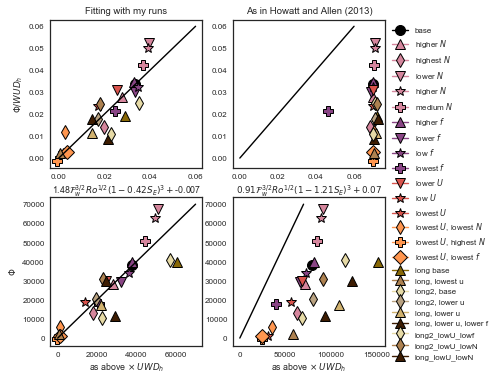

In [102]:
sns.set_context('paper')
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2, figsize=(6,6))

for rec in records_dyn[:-1]:
    if Ro(rec.u_mod,rec.f,rec.L) > 10000:
        continue
    else:
        
        ax1.plot(slope*rec.X+intercept,rec.Phi_nonDim, 
                 marker = rec.mstyle,markersize = 10,
                 color = sns.xkcd_rgb[rec.color2],
                 markeredgewidth=1.0,
                 markeredgecolor = 'k',
                 label=rec.label)
        ax2.plot(0.91*rec.X_HA+0.07,rec.Phi_nonDim, 
                 marker = rec.mstyle, markersize = 10,
                 color = sns.xkcd_rgb[rec.color2],
                 markeredgewidth=1.0,
                 markeredgecolor = 'k',
                 label=rec.label)
        ax3.plot((slope*rec.X+intercept)*(rec.u_mod*rec.W*Dh(rec.f,rec.L,rec.N)),rec.Phi, 
                 marker = rec.mstyle,markersize = 10,
                 color = sns.xkcd_rgb[rec.color2],
                 markeredgewidth=1.0,
                 markeredgecolor = 'k',
                 label=rec.label)

        ax4.plot((0.91*rec.X_HA+0.07)*(rec.u_mod*rec.W*Dh(rec.f,rec.L,rec.N)),rec.Phi, 
                 marker = rec.mstyle,markersize = 10,
                 color = sns.xkcd_rgb[rec.color2],
                 markeredgewidth=1.0,
                 markeredgecolor = 'k',
                 label=rec.label)
       # ax3.plot(((F(Ro(rec.u_mod, rec.f, rec.R))**1.5)*(Ro(rec.u_mod, rec.f, rec.L)**0.5))*(rec.u_mod*rec.Wsb*Dh(rec.f,rec.L,rec.N)),rec.Phi, 
       #          marker = rec.mstyle,markersize = 12,
       #          color = sns.xkcd_rgb[rec.color2],
       #          markeredgewidth=1.0,
       #          markeredgecolor = 'k',
       #          label=rec.label)
   
    print(rec.name, rec.f, rec.u_mod, rec.N, rec.L, rec.Wiso)
    
xx = np.linspace(0,70000,50)
ax3.plot(xx,xx,'k-')
ax4.plot(xx,xx,'k-')

xx = np.linspace(0,0.06,50)
ax1.plot(xx,xx,'k-')
ax2.plot(xx,xx,'k-')

ax1.set_ylabel('$\Phi/WUD_h$')
ax1.set_xlabel(r'%1.2f$\mathcal{F}_w^{3/2}Ro^{1/2}(1-%1.2f S_E)^3+$%1.3f' %(slope, param, intercept))
ax2.set_xlabel(r'$0.91\mathcal{F}_w^{3/2}Ro^{1/2}(1-1.21S_E)^3+0.07$')

ax3.set_ylabel('$\Phi$')
ax3.set_xlabel(r'as above $\times$ $UWD_h$')
ax4.set_xlabel(r'as above $\times$ $UWD_h$')

ax1.set_title('Fitting with my runs')
ax2.set_title(r'As in Howatt and Allen (2013)')
#ax3.set_title(r'As in Allen and Hickey (2010)')

ax2.legend(bbox_to_anchor=(1.0,1),ncol=1, columnspacing=0.1)
plt.savefig('Phi_with_Ls.eps', format='eps', bbox_inches='tight')


In [70]:
Se = SE(0.01, 0.0055, 9.66E-5, 0.57, Ro(0.35,9.66E-5,8332))
    
X_HA = ((0.57)**(1.5))*((Ro(0.35,9.66E-5,8332))**(0.5))*((1-1.21*Se)**3)

print(0.91*X_HA+0.07)

0.0863134263380557


In [69]:
F(Ro(0.35,9.66E-5,3000))

0.5730002292000916

In [66]:
 Ro(0.35,7.66E-5,8332)

0.5483906145609929